# Baseline model

1. Same padding をやめて valid に
  * その結果、画像が小さくなってしまったので Conv を３段から２段に
 
2. ~最後の dropout をなくす~


## 結果

* Conv を一段減らして 6 から 4 にしても精度はそのままだった.
* ただしDropout をひとつにしたら overfitting になった.  乱暴な dropout は精度を落とさず、overfitting を抑えていた

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F  # F.relu とか

print('PyTorch version', torch.__version__)


# GPU が使えるなら使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

if torch.cuda.is_available():
  print('GPU:', torch.cuda.get_device_name(0))

PyTorch version 1.1.0
Device: cuda:0
GPU: Tesla T4


## MNIST data

In [0]:
# データが PIL.Image なので、torch.Tensor に変換する
to_tensor = torchvision.transforms.ToTensor()

train = torchvision.datasets.MNIST(root='./input', train=True,
                                   download=True, transform=to_tensor)
test = torchvision.datasets.MNIST(root='./input', train=False,
                                  transform=to_tensor)
print(train)
print(test)

0it [00:00, ?it/s]

9920512it [00:01, 9459521.19it/s]                            


Extracting ./input/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 138488.28it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./input/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2274580.78it/s]                            
0it [00:00, ?it/s]

Extracting ./input/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 52163.43it/s]            


Extracting ./input/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./input
    Split: Train
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./input
    Split: Test


In [0]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [0]:
class BaseNet(nn.Module):
    def __init__(self):
        # ここでは各レイヤーを定義しているだけ。繋がっていない
        # Sequential を使って __init__ 時点でつなぐ流儀もある
        super(BaseNet, self).__init__()
        self.conv1a = nn.Conv2d(1,  16, 3)  # 28x28x1  -> 26x26x16
        self.conv1b = nn.Conv2d(16, 16, 3)  # 26x26x16 -> 24x24x16 
        self.pool1  = nn.MaxPool2d(2, 2)    # 24x24x16 -> 12x12x16
        self.conv2a = nn.Conv2d(16, 32, 3)  # 12x12x16 -> 10x10x32
        self.conv2b = nn.Conv2d(32, 32, 3)  # 10x10x32 -> 8x8x32
        self.pool2  = nn.MaxPool2d(2, 2)    # 8x8x32 -> 4x4x32
        self.fc1    = nn.Linear(4 * 4 * 32, 50)  # fully connected -> 50
        self.dropout1 = nn.Dropout2d()           # default dropout rate is 0.5
        self.fc2      = nn.Linear(50, 10)        # 50 -> 10 number of classes
        self.dropout2 = nn.Dropout2d()

    def forward(self, x):
        # レイヤーをつなげている
        x = F.relu(self.conv1a(x))
        x = F.relu(self.conv1b(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2a(x))
        x = F.relu(self.conv2b(x))
        x = self.pool2(x)
        
        x = x.view(-1, 4 * 4 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.dropout2(x)

        return x

In [0]:
# Model と 最適化方法
model = BaseNet()
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)  # send to GPU if available

# 訓練の進行具合を記録
def measure_scores(name, loader, history, *, nbatch=100):
    loss_sum = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader, 0):
            # send data to GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = model(images)
            loss = cross_entropy(outputs, labels)
            loss_sum += loss
                
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i + 1 == nbatch:
              break

    # average loss during the epoch
    loss_average = loss_sum / len(train_loader)
    accuracy = correct/total
    
    history[name + '_loss'].append(loss_average)
    history[name + '_accuracy'].append(accuracy)
            
            
epochs = 20
history = {'train_loss': [], 'test_loss': [],
           'train_accuracy': [], 'test_accuracy': []}
times_train = []
times_test = []

for iepoch in range(epochs):
    model.train()  # 訓練モード
    time_train = 0.0
    for i, (images, labels) in enumerate(train_loader, 0): 
        ts = time.time()
        
        # send data to GPU
        images = images.to(device)
        labels = labels.to(device)
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        te = time.time()
        time_train += (te - ts)
    
    times_train.append(time_train)
    
    # Measure test accuracy for each epoch
    ts = time.time()
    
    model.eval()  # evaluation モード; dropout しないなど
    
    measure_scores('train', train_loader, history)    
    measure_scores('test', test_loader, history)
    
    
    te = time.time()
    times_test.append(te - ts)
    
    print('Epoch %d: loss %.4e %.4e, Test accuracy %.6f' % (iepoch + 1,
          history['train_loss'][-1],
          history['test_loss'][-1],
          history['test_accuracy'][-1]))

    
print('Finished Training')
print('Training %.2f ± %.2f sec per epoch' % (np.mean(times_train), np.std(times_train)))
print('Test evaluation %.4f ± %.4f sec per epoch' % (np.mean(times_test), np.std(times_test)))
print('Total %.2f sec' % (np.sum(times_test) + np.sum(times_test)))

Epoch 1: loss 1.8867e-02 1.6925e-02, Test accuracy 0.974300
Epoch 2: loss 1.3331e-02 1.2300e-02, Test accuracy 0.980600
Epoch 3: loss 1.0302e-02 9.0464e-03, Test accuracy 0.984100
Epoch 4: loss 8.6627e-03 8.9824e-03, Test accuracy 0.985700
Epoch 5: loss 6.8187e-03 6.6736e-03, Test accuracy 0.988400
Epoch 6: loss 6.6498e-03 6.1399e-03, Test accuracy 0.989800
Epoch 7: loss 6.7787e-03 6.7934e-03, Test accuracy 0.989000
Epoch 8: loss 5.8660e-03 6.0283e-03, Test accuracy 0.989600
Epoch 9: loss 5.4461e-03 6.0495e-03, Test accuracy 0.988200
Epoch 10: loss 4.2658e-03 5.5289e-03, Test accuracy 0.990200
Epoch 11: loss 4.6534e-03 5.5314e-03, Test accuracy 0.990700
Epoch 12: loss 5.1547e-03 6.4433e-03, Test accuracy 0.989100
Epoch 13: loss 4.2071e-03 5.0602e-03, Test accuracy 0.991000
Epoch 14: loss 4.2180e-03 4.7918e-03, Test accuracy 0.992000
Epoch 15: loss 3.2928e-03 4.8483e-03, Test accuracy 0.991200
Epoch 16: loss 3.7085e-03 5.2372e-03, Test accuracy 0.991000
Epoch 17: loss 2.8822e-03 5.0043e

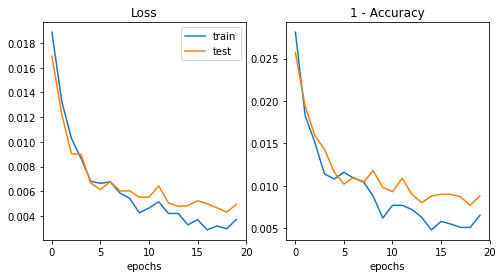

In [0]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('epochs')
plt.plot(history['train_loss'], label='train')
plt.plot(history['test_loss'], label='test')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('1 - Accuracy')
plt.xlabel('epochs')
plt.plot(1 - np.array(history['train_accuracy']))
plt.plot(1 - np.array(history['test_accuracy']))
plt.show()

* 1 dropout では Overfitting の気配がある
* 2 dropout だといい感じ